# Analysis of environmental data
In this notebook, we will analyze the oceanographic data collected during the Spring Campaign of 2023. The data was collected using a CTD (Conductivity, Temperature, Depth) sensor and the ships underway system. The CTD sensor was deployed every hour at 4 different locations in the Southern North Sea. We'll start with importing the data into this notebook for analysis.

In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

## Map
First, we'll plot the location of the study on a map.

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_4893/3267812514.py:8: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


AttributeError: Stamen

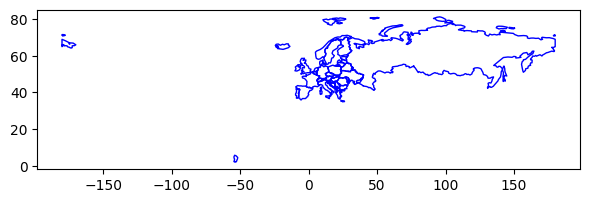

In [59]:
# Define a function to plot Belgian Part of the North Sea with sampling stations
def plot_north_sea_bathymetry(stations):
    # Create a GeoDataFrame for the Belgian Part of the North Sea (BPN)
    # The bounding box here is approximate for the Belgian Part of the North Sea.
    bbox = [1.8, 51, 3.8, 52]
    
    # Create an empty GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=gpd.points_from_xy([], []))
    
    # Plot the North Sea using a basemap (contextily will download a basemap, including bathymetry)
    fig, ax = plt.subplots(figsize=(7, 5))
    gdf.plot(ax=ax, alpha=0)
    
    # Add bathymetry layer from contextily basemap
    ctx.add_basemap(ax, crs='EPSG:4326', source=ctx.providers.Esri.OceanBasemap)
    
    # Plot sampling stations
    station_gdf = gpd.GeoDataFrame(
        stations, 
        geometry=gpd.points_from_xy(stations["Longitude"], stations["Latitude"]),
        crs="EPSG:4326"
    )
    station_gdf.plot(ax=ax, color='black', marker='o', label='Sampling Stations', markersize=50)

    # Add station labels
    for x, y, label in zip(station_gdf.geometry.x, station_gdf.geometry.y, station_gdf["Name"]):
        ax.text(x, y, label, fontsize=12, ha='right', color='black')

    # Set plot limits to the Belgian Part of the North Sea
    ax.set_xlim(bbox[0], bbox[2])
    ax.set_ylim(bbox[1], bbox[3])

    # Add labels and title
    ax.set_title('Belgian Part of the North Sea with Bathymetry and Sampling Stations')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    # Show plot
    plt.show()

# Coordinates of the sampling stations
stations = {
    'Name': ['51', '130'],
    'Latitude': [51.53166115, 51.21634923],
    'Longitude': [3.18280367, 2.85125683]
}

# Convert to pandas DataFrame
stations_df = pd.DataFrame(stations)

# Plot
plot_north_sea_bathymetry(stations_df)


/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_4893/2535160039.py:35: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


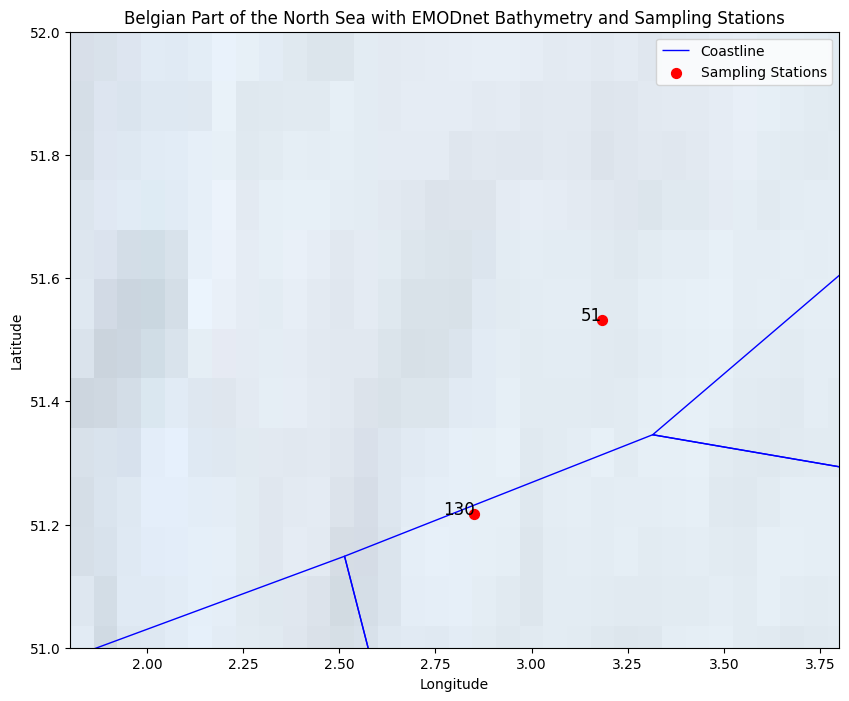

In [60]:
from owslib.wms import WebMapService
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from PIL import Image
from io import BytesIO
import requests

# Function to plot EMODnet bathymetry with sampling stations
def plot_emodnet_bathymetry_with_stations(stations):
    # Connect to the EMODnet WMS service for bathymetry
    wms = WebMapService('https://ows.emodnet-bathymetry.eu/wms', version='1.3.0')

    # Define the bounding box (Belgian Part of the North Sea)
    bbox = (1.8, 51.0, 3.8, 52.0)  # (minx, miny, maxx, maxy)

    # Request bathymetry image from EMODnet (bounding box in EPSG:4326)
    img = wms.getmap(layers=['emodnet:mean_atlas_land'],
                     srs='EPSG:4326',
                     bbox=bbox,
                     size=(800, 600),
                     format='image/png',
                     transparent=True)
    
    # Read the image data
    image = Image.open(BytesIO(img.read()))

    # Create a plot
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Display the EMODnet bathymetry image
    ax.imshow(image, extent=bbox, origin='upper')

    # Load a simplified world map for the coastline
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    europe = world[world['continent'] == 'Europe']
    
    # Plot the coastline
    europe.boundary.plot(ax=ax, linewidth=1, color='blue', label='Coastline')
    
    # Plot sampling stations
    station_gdf = gpd.GeoDataFrame(
        stations, 
        geometry=gpd.points_from_xy(stations["Longitude"], stations["Latitude"]),
        crs="EPSG:4326"
    )
    station_gdf.plot(ax=ax, color='red', marker='o', label='Sampling Stations', markersize=50)

    # Add station labels
    for x, y, label in zip(station_gdf.geometry.x, station_gdf.geometry.y, station_gdf["Name"]):
        ax.text(x, y, label, fontsize=12, ha='right', color='black')

    # Set plot limits to the Belgian Part of the North Sea
    ax.set_xlim(bbox[0], bbox[2])
    ax.set_ylim(bbox[1], bbox[3])

    # Add labels and title
    ax.set_title('Belgian Part of the North Sea with EMODnet Bathymetry and Sampling Stations')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')

    plt.legend()
    plt.show()

# Coordinates of the sampling stations
stations = {
    'Name': ['51', '130'],
    'Latitude': [51.53166115, 51.21634923],
    'Longitude': [3.18280367, 2.85125683]
}

# Convert to pandas DataFrame
stations_df = pd.DataFrame(stations)

# Plot with EMODnet bathymetry and stations
plot_emodnet_bathymetry_with_stations(stations_df)


## CTD Data

In [5]:
ctd_data = pd.read_csv('../data/raw/environmental_data.csv', sep=';', index_col=0)
# Make sure the index is a DateTimeIndex type to manipulate dates efficiently
ctd_data.index = pd.to_datetime(ctd_data.index)

# Only include data from stations 51 and 130
ctd_data = ctd_data[ctd_data['StationPrefix'].isin(['51', '130'])]

# It looks like the time is off by two hours (it is in UST), so we'll add two hours to the index
ctd_data.index = ctd_data.index + pd.Timedelta(hours=2)

In [6]:
ctd_data['Day'].unique()

array([18, 19, 20, 21])

Now, let's add time of high and low tides. We downloaded tidal predictions from the [Flanders Maritime Agency](https://www.agentschapmdk.be/nl/publicaties#getijgegevens-2023), and used the tables for Vlissingen (Station 51) and Ostend (Station 130). In Vlissingen we sampled from 18/04/2023 13:00 to 19/04/2023 09:00. In Ostend we sampled from 20/4/2023 10:00 to 21/4/2023 10:00. Here's the values:

| Location | Date | high tide | low tide | station |
| :-------: | :--------: | :---: | :----------: | :---: |
| Vlissingen | 18/04/2023 | 13:52 | 20:12 | 51 |
| Vlissingen | 19/04/2023 | 02:06 | 08:40 | 51 |
| Ostend | 20/04/2023 | 01:45 | 08:33 | 130 |
| Ostend | 20/04/2023 | 14:12 | 20:50 | 130 |
| Ostend | 21/04/2023 | 02:26 | 09:14 | 130 |

In [7]:
# Create a tides dataframe
tides_df = pd.DataFrame({
    'Location': ['Vlissingen', 'Vlissingen', 'Ostend', 'Ostend'],
    'Datetime_high_tide': pd.to_datetime(['18/04/2023 13:52', '19/04/2023 02:06', 
                                          '20/04/2023 14:12', '21/04/2023 02:26']),
    'Datetime_low_tide': pd.to_datetime(['18/04/2023 20:12', '19/04/2023 08:40', 
                                         '20/04/2023 20:50', '21/04/2023 09:14']),
    'Station': [51, 51, 130, 130]
})

/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_4893/2416954571.py:4: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  'Datetime_high_tide': pd.to_datetime(['18/04/2023 13:52', '19/04/2023 02:06',
/var/folders/sw/y59p6zb57zd9ntdpcr65r3q40000gn/T/ipykernel_4893/2416954571.py:6: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  'Datetime_low_tide': pd.to_datetime(['18/04/2023 20:12', '19/04/2023 08:40',


In [8]:
def plot_environmental_variable(ctd_data, tides_df, variable, y_limits, output_dir):
    """
    Plot the specified environmental variable over time, colored per station.
    It will also add vertical lines for high and low tides, and shade the period between them.

    Parameters:
    ctd_data (DataFrame): The CTD data containing the environmental variables.
    tides_df (DataFrame): The tides data containing high and low tide times.
    variable (str): The name of the environmental variable to plot.
    y_limits (tuple): The y-axis limits for the plot.
    output_dir (str): The directory where the plot files will be saved.
    """

    # Initiate the plot
    fig, ax = plt.subplots(figsize=(12, 5))

    # Creating the lineplot
    sns.lineplot(x=ctd_data.index, y=variable,
                 hue="StationPrefix",
                 style="StationPrefix",
                 markers=True,
                 dashes=False,
                 data=ctd_data, ax=ax)

    # Setting the title with the parameter being plotted
    ax.set_title(f'{variable} Over Time')

    # Set y axis limits
    ax.set_ylim(y_limits)

    # Formatting the x-axis to show day and month
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

    # Showing time every 4 hours
    ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 4)))
    ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

    # Rotating and showing the x-axis labels
    ax.tick_params(axis='x', rotation=45)
    plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)

    # Showing a grid
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Add vertical lines and shaded regions for high and low tides
    for index, row in tides_df.iterrows():
        if str(row['Station']) in ctd_data['StationPrefix'].unique():
            if ctd_data.index.min() <= row['Datetime_high_tide'] <= ctd_data.index.max():
                ax.axvline(row['Datetime_high_tide'], color='#FB5656', linestyle='-', linewidth=1)
                high_tide_time = row['Datetime_high_tide']
            if ctd_data.index.min() <= row['Datetime_low_tide'] <= ctd_data.index.max():
                ax.axvline(row['Datetime_low_tide'], color='#89BCD6', linestyle='-', linewidth=1)
                low_tide_time = row['Datetime_low_tide']
                # Add grey background for the period between high and low tides
                if 'high_tide_time' in locals() and high_tide_time < low_tide_time:
                    ax.axvspan(high_tide_time, low_tide_time, color='lightgrey', alpha=0.3)
                    del high_tide_time

    # Saving the plot as a .svg and .png file
    plt.savefig(f'{output_dir}/{variable}.svg', format='svg')
    plt.savefig(f'{output_dir}/{variable}.png', format='png')
    # Display the plot
    plt.show()

def plot_environmental_variable_per_station(ctd_data, tides_df, variable, y_limits, output_dir):
    """
    Plot the specified environmental variable over time, per station.
    It will also add vertical lines for high and low tides, and shade the period between them.

    Parameters:
    ctd_data (DataFrame): The CTD data containing the environmental variables.
    tides_df (DataFrame): The tides data containing high and low tide times.
    variable (str): The name of the environmental variable to plot.
    y_limits (tuple): The y-axis limits for the plot.
    output_dir (str): The directory where the plot files will be saved.
    """
    
    # List of unique station prefixes
    stations = ctd_data['Station'].str.split('_').str[0].unique()

    # Loop over each station to create individual plots
    for station in stations:
        station_data = ctd_data[ctd_data['Station'].str.startswith(station)]
        station_tides = tides_df[tides_df['Station'] == int(station)]
        
        # Plot the average environmental variable over time for the current station
        fig, ax = plt.subplots(figsize=(5, 4))

        # Creating the lineplot
        sns.lineplot(x=station_data.index, y=variable,
                     hue="StationPrefix",
                     style="StationPrefix",
                     markers=True,
                     dashes=False,
                     data=station_data, ax=ax)

        # Setting the title with the parameter being plotted
        ax.set_title(f'{variable} Over Time - Station {station}')

        # Set y axis limits
        ax.set_ylim(y_limits)

        # Formatting the x-axis to show day and month
        ax.xaxis.set_major_locator(mdates.DayLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))

        # Showing time every 4 hours
        ax.xaxis.set_minor_locator(mdates.HourLocator(byhour=range(0, 24, 4)))
        ax.xaxis.set_minor_formatter(mdates.DateFormatter('%H:%M'))

        # Rotating and showing the x-axis labels
        ax.tick_params(axis='x', rotation=45)
        plt.setp(ax.xaxis.get_minorticklabels(), rotation=45)

        # Showing a grid
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)

        # Add vertical lines and shaded regions for high and low tides
        for index, row in station_tides.iterrows():
            if station_data.index.min() <= row['Datetime_high_tide'] <= station_data.index.max():
                ax.axvline(row['Datetime_high_tide'], color='#FB5656', linestyle='-', linewidth=1)
                high_tide_time = row['Datetime_high_tide']
            if station_data.index.min() <= row['Datetime_low_tide'] <= station_data.index.max():
                ax.axvline(row['Datetime_low_tide'], color='#89BCD6', linestyle='-', linewidth=1)
                low_tide_time = row['Datetime_low_tide']
                # Add grey background for the period between high and low tides
                if 'high_tide_time' in locals() and high_tide_time < low_tide_time:
                    ax.axvspan(high_tide_time, low_tide_time, color='lightgrey', alpha=0.3)
                    del high_tide_time

        # Saving the plot as .svg and .png files with station prefix and variable name in the filename
        plt.savefig(f'{output_dir}/{variable}_{station}.svg', format='svg')
        plt.savefig(f'{output_dir}/{variable}_{station}.png', format='png')
        # Display the plot
        plt.show()

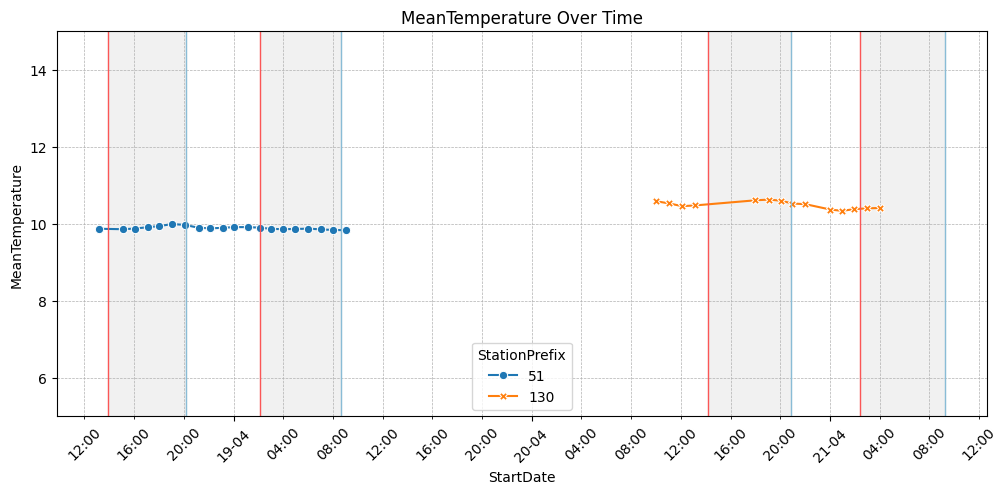

In [9]:
plot_environmental_variable(ctd_data, tides_df, 'MeanTemperature', (5, 15), '../figures/environmental')

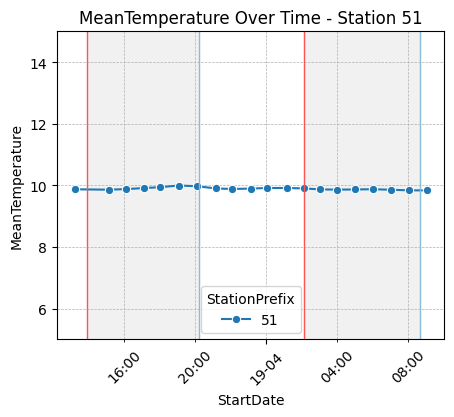

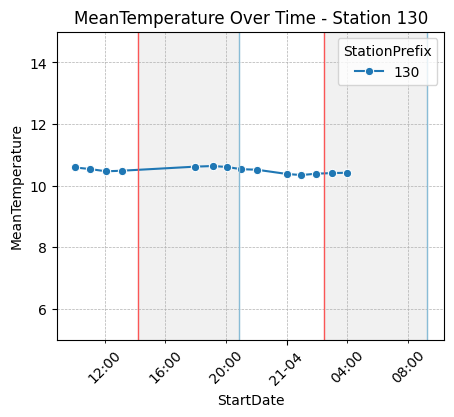

In [10]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanTemperature', (5, 15), '../figures/environmental')

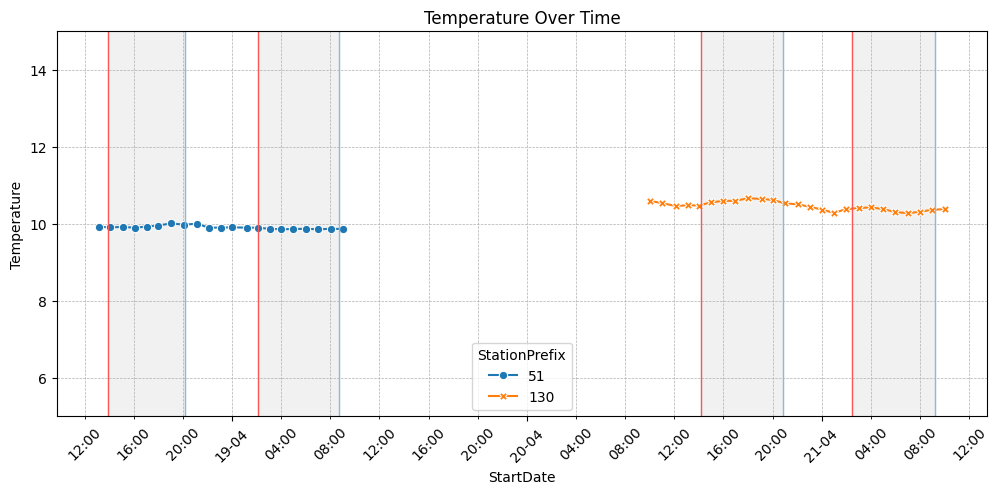

In [11]:
plot_environmental_variable(ctd_data, tides_df, 'Temperature', (5, 15), '../figures/environmental')

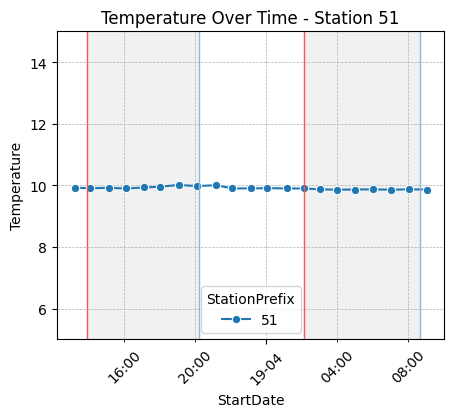

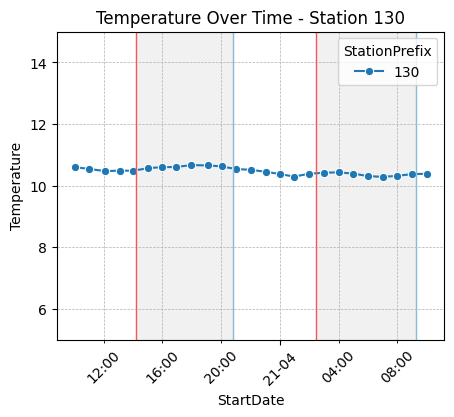

In [12]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'Temperature', (5, 15), '../figures/environmental')

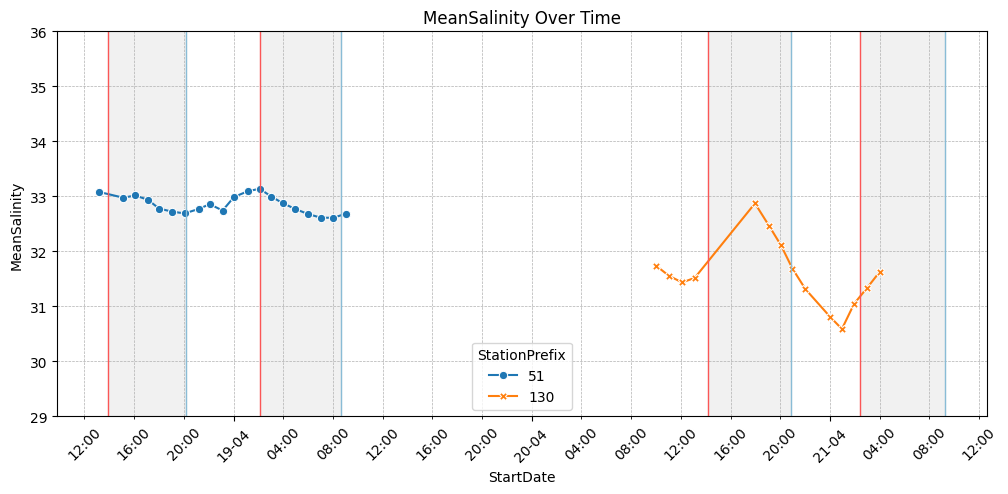

In [13]:
plot_environmental_variable(ctd_data, tides_df, 'MeanSalinity', (29, 36), '../figures/environmental')

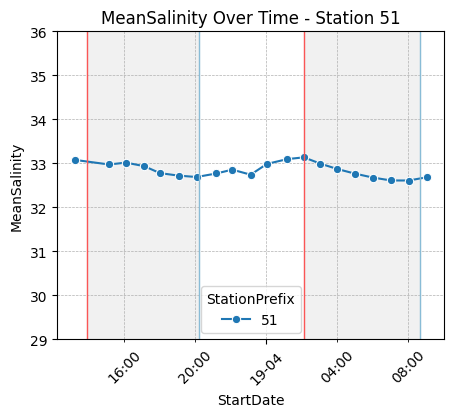

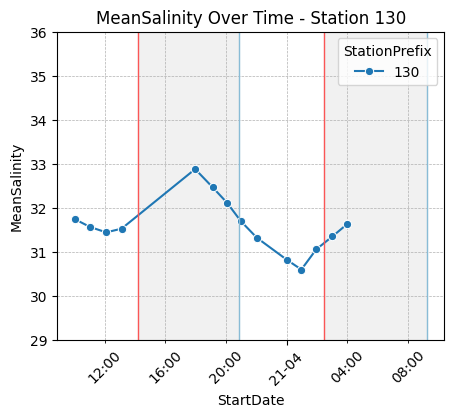

In [14]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanSalinity', (29, 36), '../figures/environmental')

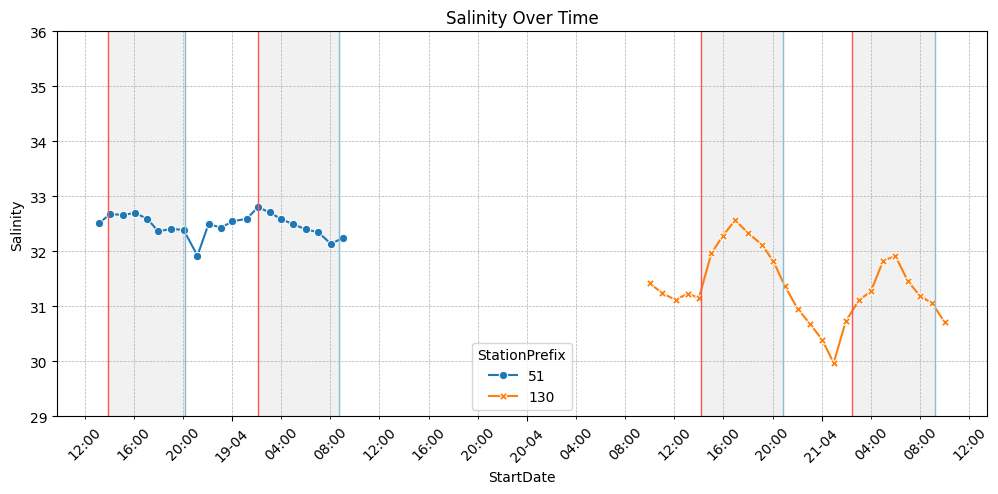

In [15]:
plot_environmental_variable(ctd_data, tides_df, 'Salinity', (29, 36), '../figures/environmental')

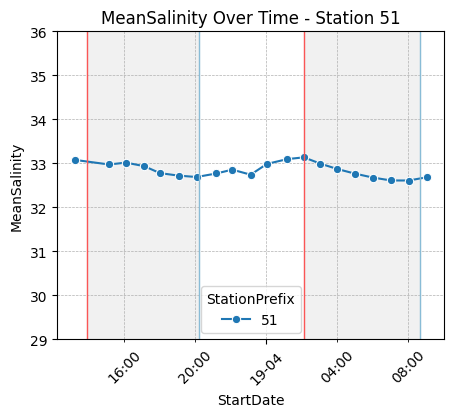

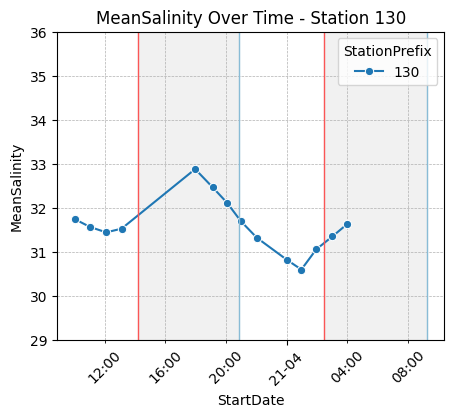

In [16]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanSalinity', (29, 36), '../figures/environmental')

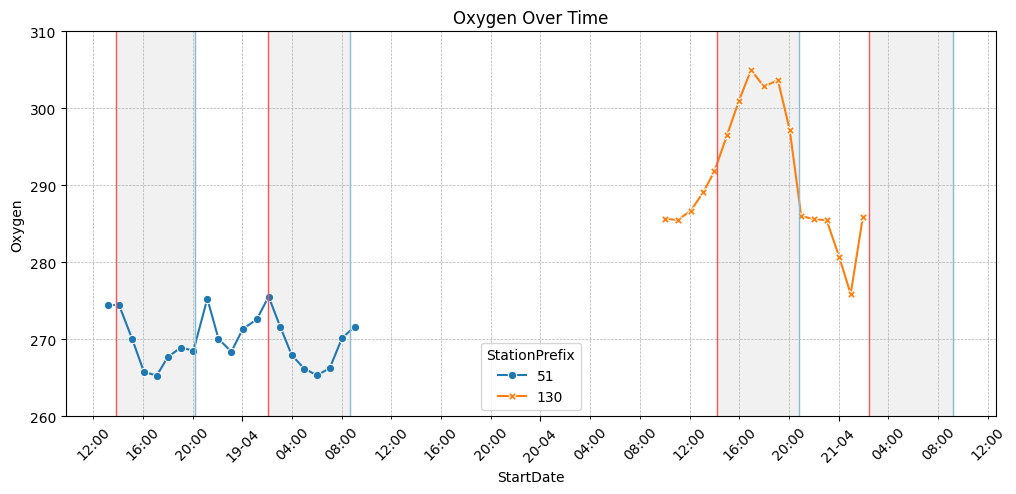

In [17]:
plot_environmental_variable(ctd_data, tides_df, 'Oxygen', (260, 310), '../figures/environmental')

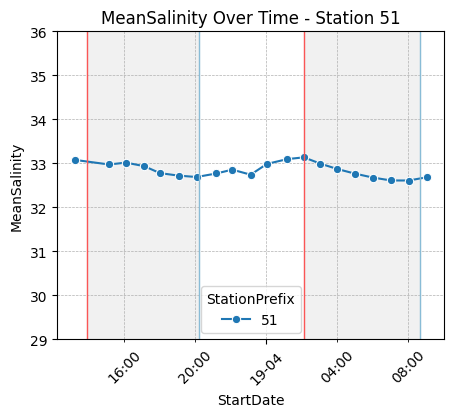

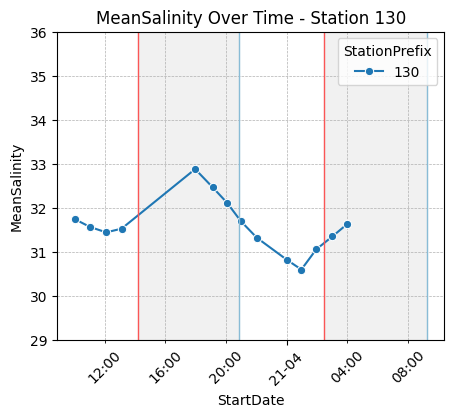

In [18]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanSalinity', (29, 36), '../figures/environmental')

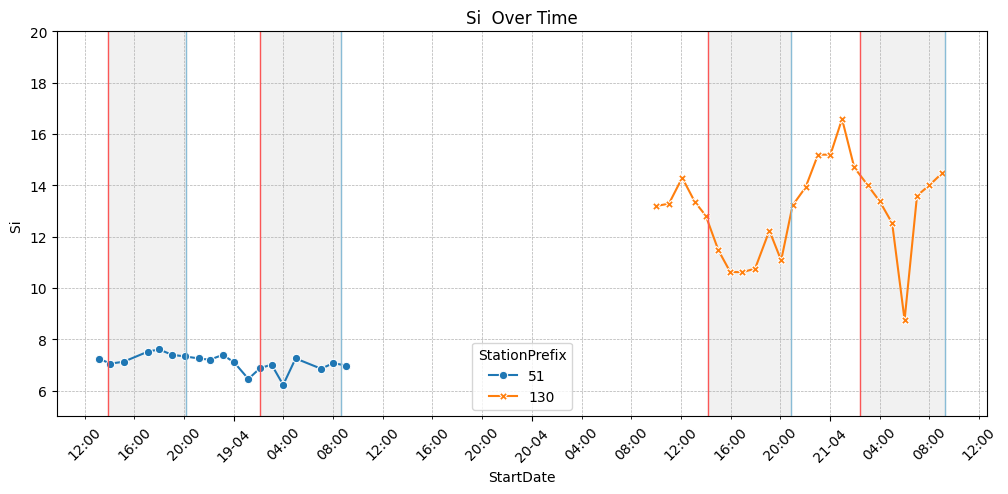

In [19]:
plot_environmental_variable(ctd_data, tides_df, 'Si ', (5, 20), '../figures/environmental')

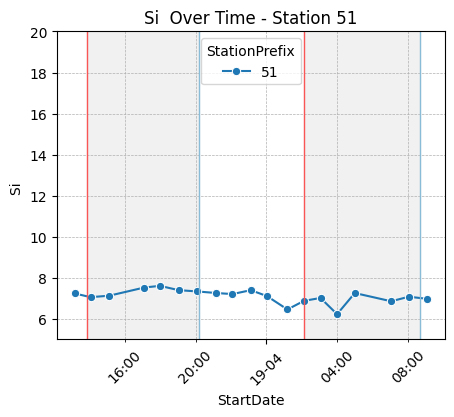

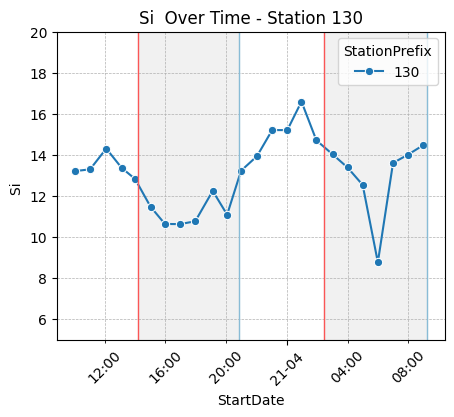

In [20]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'Si ', (5, 20), '../figures/environmental')

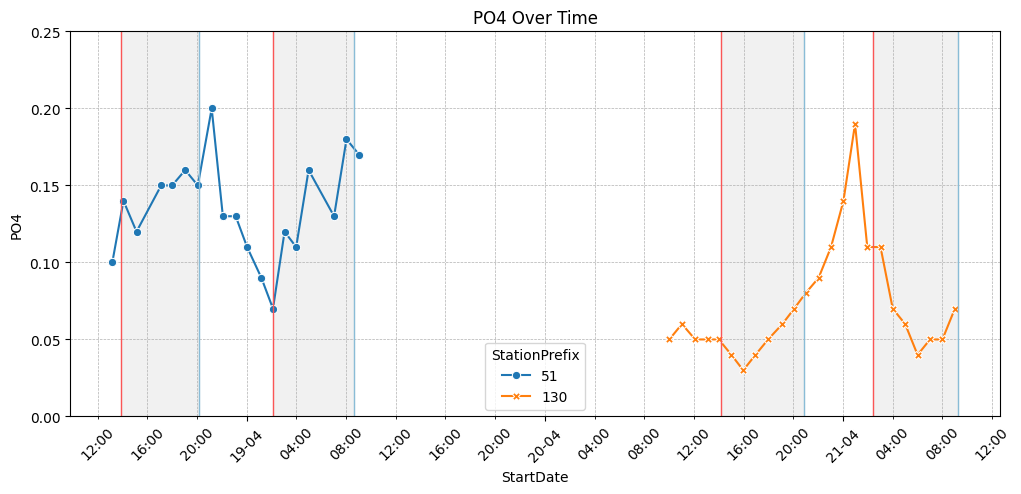

In [21]:
plot_environmental_variable(ctd_data, tides_df, 'PO4', (0, 0.25), '../figures/environmental')

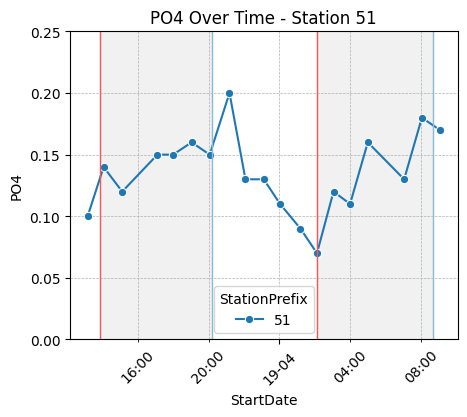

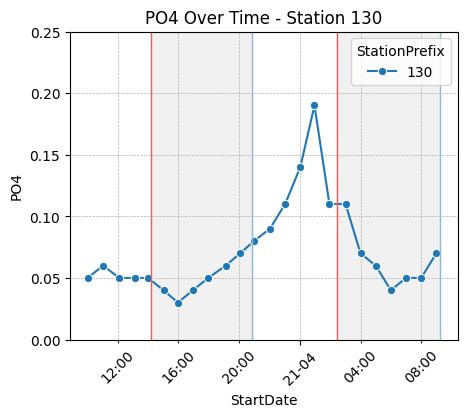

In [22]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'PO4', (0, 0.25), '../figures/environmental')

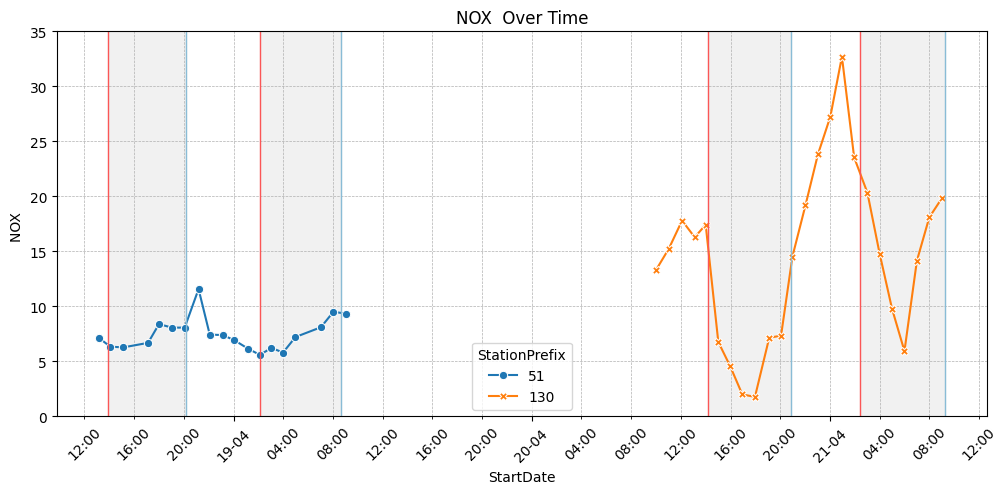

In [23]:
plot_environmental_variable(ctd_data, tides_df, 'NOX ', (0, 35), '../figures/environmental')

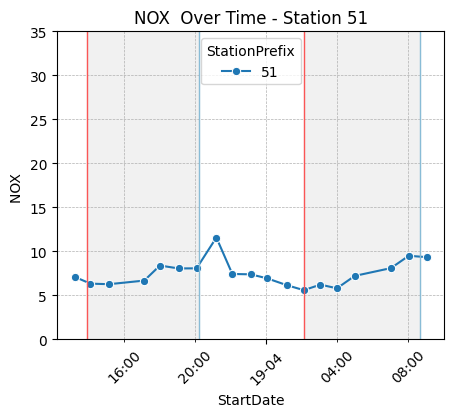

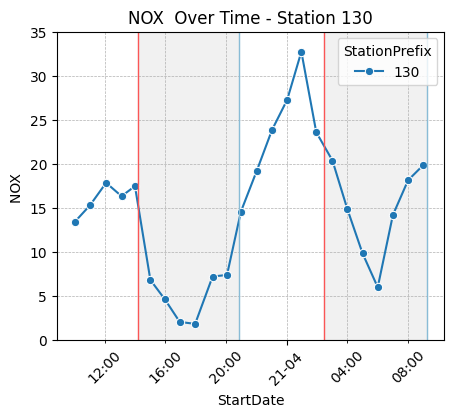

In [24]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'NOX ', (0, 35), '../figures/environmental')

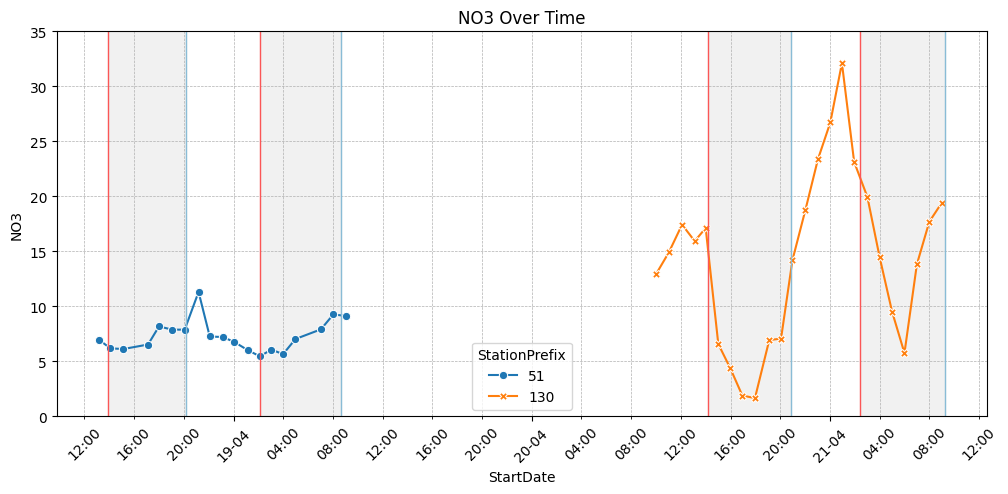

In [25]:
plot_environmental_variable(ctd_data, tides_df, 'NO3', (0, 35), '../figures/environmental')

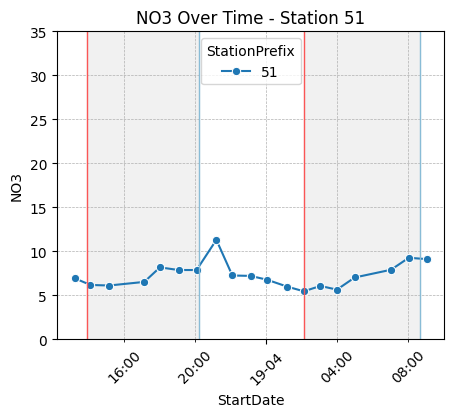

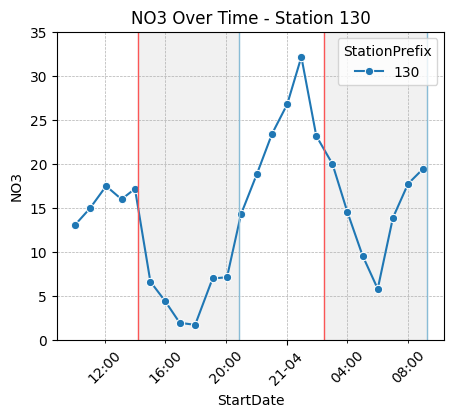

In [26]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'NO3', (0, 35), '../figures/environmental')

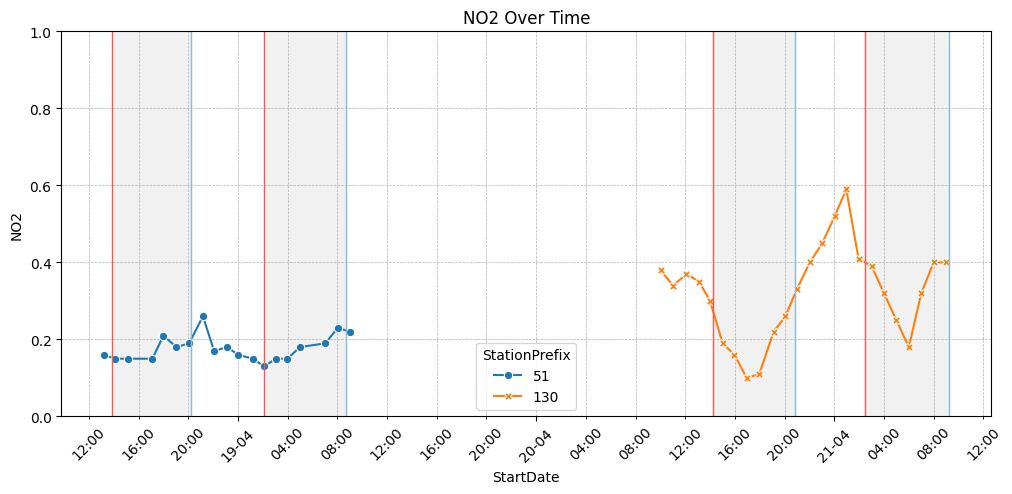

In [27]:
plot_environmental_variable(ctd_data, tides_df, 'NO2', (0, 1), '../figures/environmental')

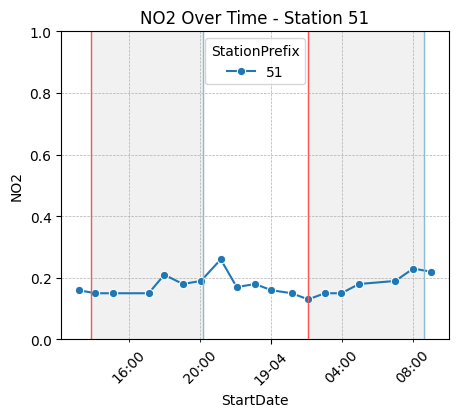

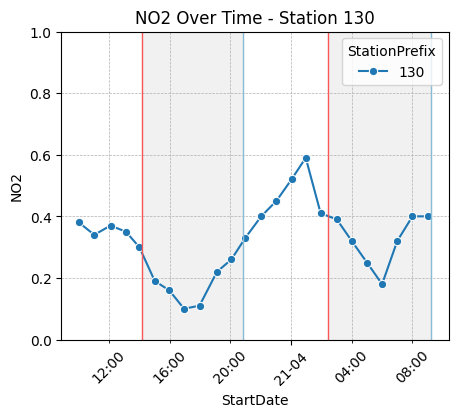

In [28]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'NO2', (0, 1), '../figures/environmental')

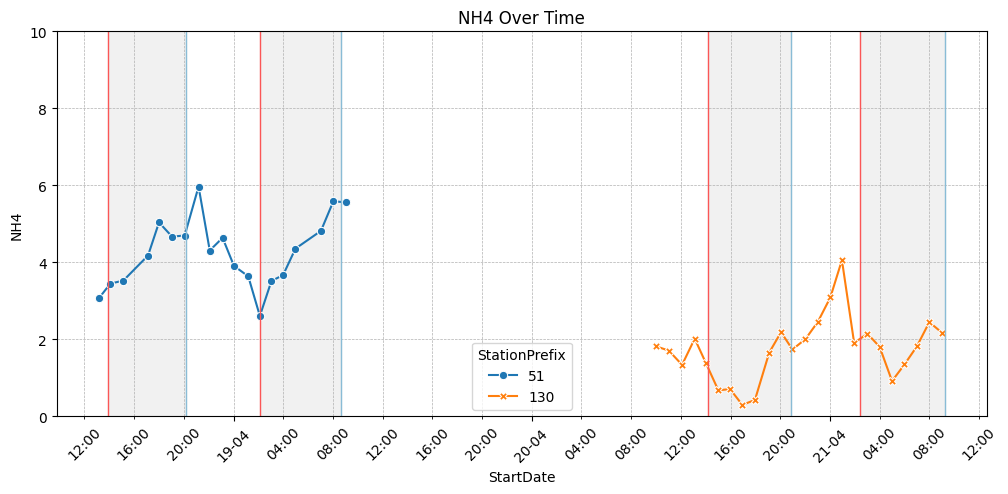

In [29]:
plot_environmental_variable(ctd_data, tides_df, 'NH4', (0, 10), '../figures/environmental')

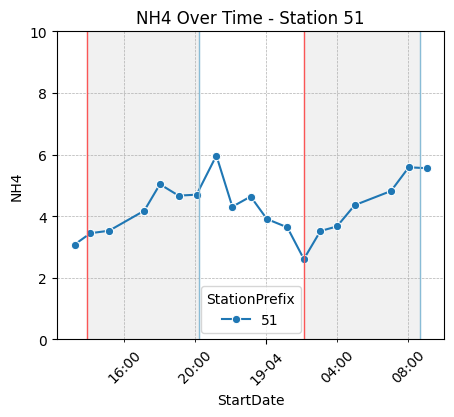

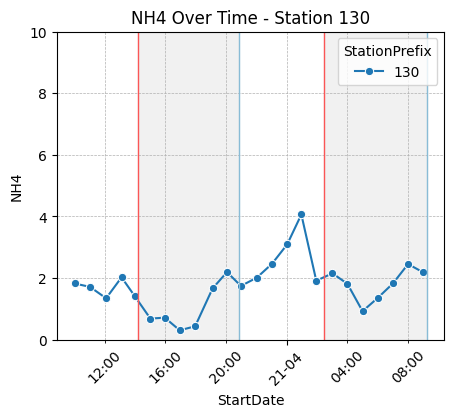

In [30]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'NH4', (0, 10), '../figures/environmental')

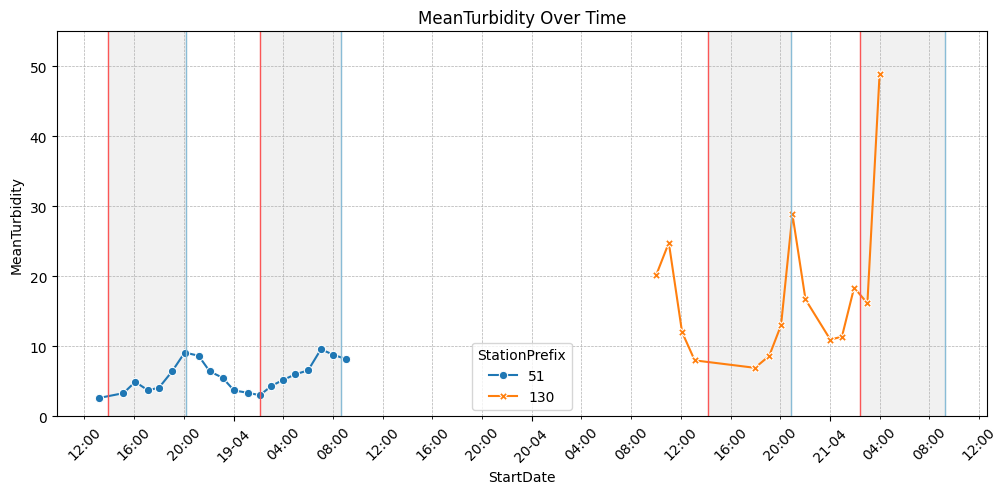

In [31]:
plot_environmental_variable(ctd_data, tides_df, 'MeanTurbidity', (0, 55), '../figures/environmental')

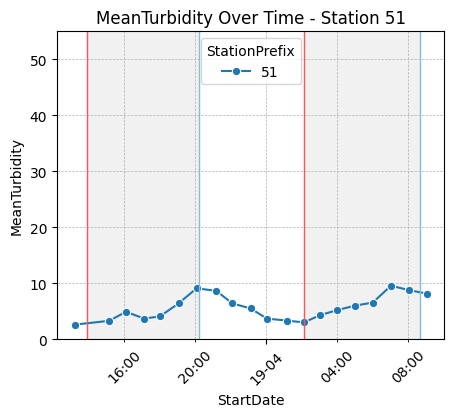

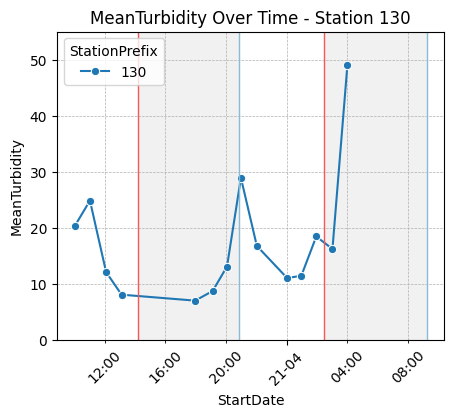

In [32]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanTurbidity', (0, 55), '../figures/environmental')

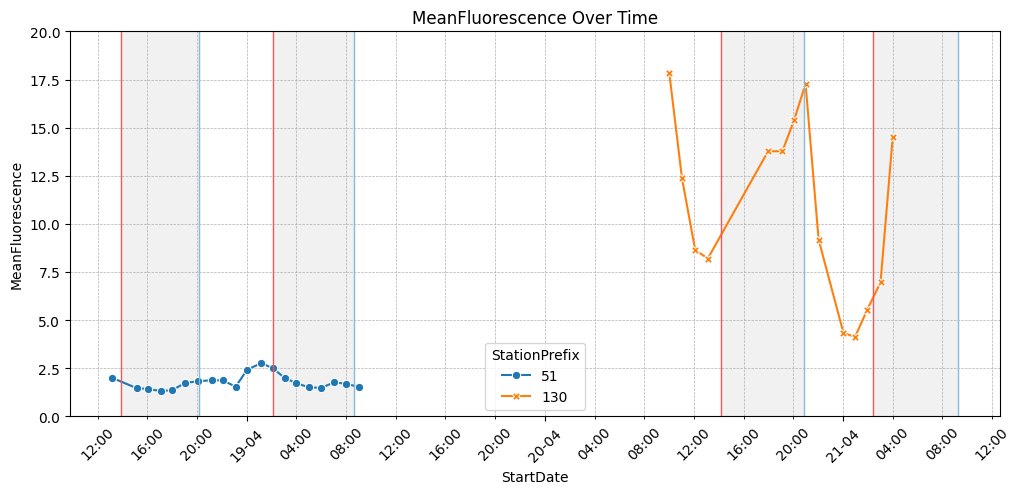

In [33]:
plot_environmental_variable(ctd_data, tides_df, 'MeanFluorescence', (0, 20), '../figures/environmental')

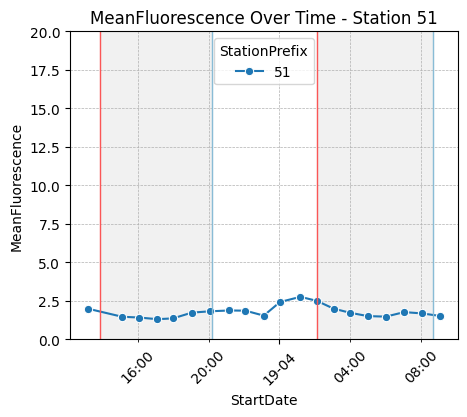

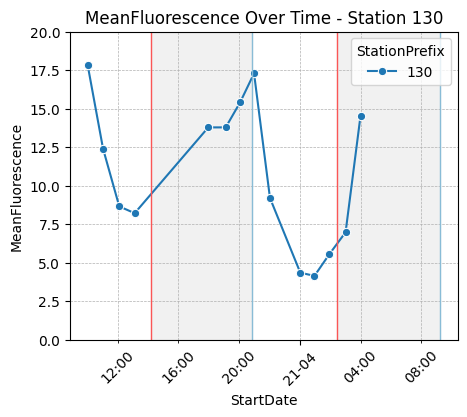

In [34]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanFluorescence', (0, 20), '../figures/environmental')

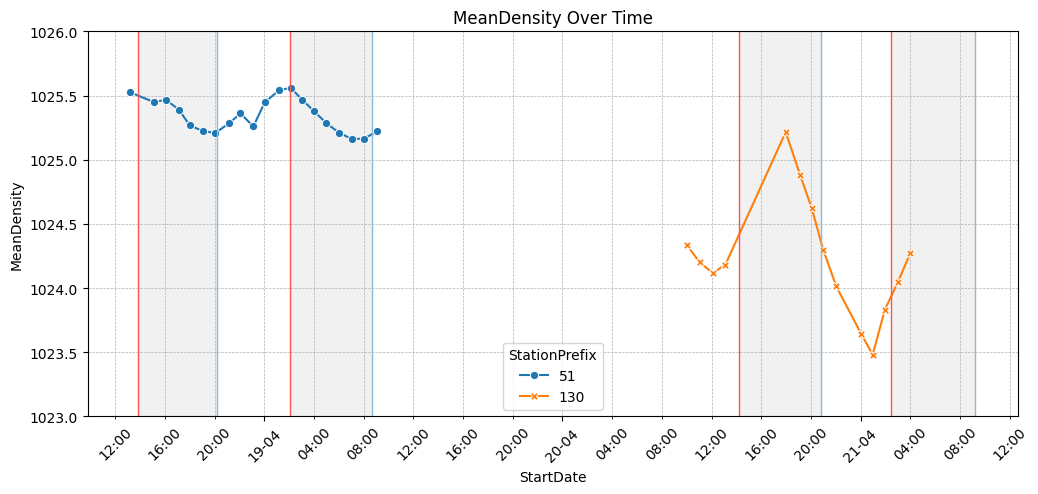

In [35]:
plot_environmental_variable(ctd_data, tides_df, 'MeanDensity', (1023, 1026), '../figures/environmental')

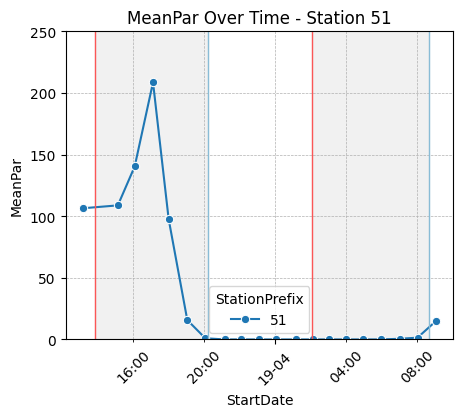

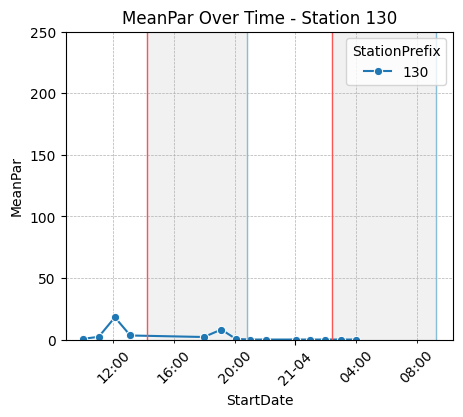

In [36]:
plot_environmental_variable_per_station(ctd_data, tides_df, 'MeanPar', (0, 250), '../figures/environmental')


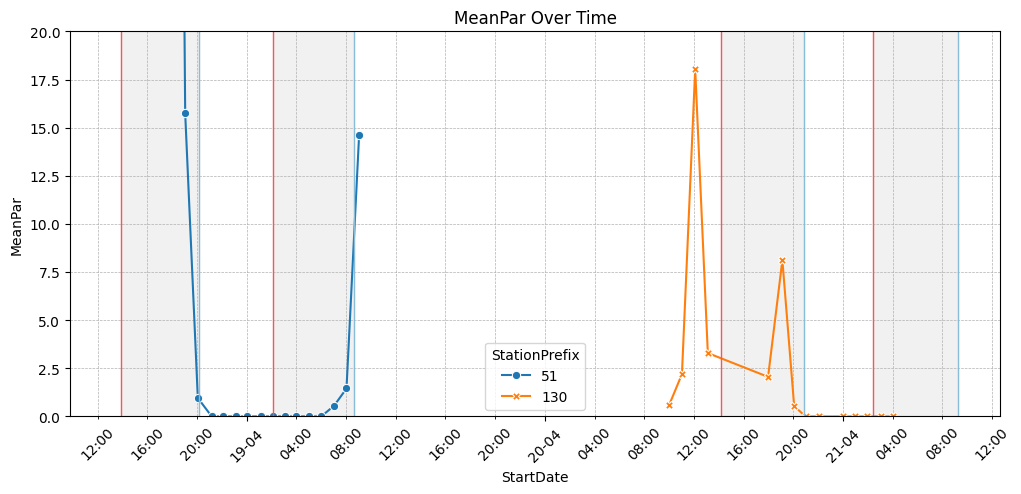

In [37]:
plot_environmental_variable(ctd_data, tides_df, 'MeanPar', (0, 20), '../figures/environmental')

## Create environmental dataset for analysis
Here we'll combine the LW data, and buoy data, with sampling metadata in order to generate an easy dataset to work with in subsequent analyses. We'll pull in additional data using [bpnsdata](https://github.com/lifewatch/bpnsdata) if available.

In [41]:
# Clone the github package to the local machine and add it to the path
import sys
import os
sys.path.append('../../bpnsdata')
import bpnsdata
import geopandas as gpd
from suntime import Sun

In [42]:
os.environ['username_banken'] = 'michiel.perneel@vliz.be'
os.environ['password_banken'] = 'zYjjoj-kumtav-4himqe'

In [43]:
# Add date column to the ctd_data
ctd_data['Date'] = ctd_data.index

# Run the sea_manager over every row in the dataframe for the ERDDAP data
env_vars = ['shipping', 'time', 'wrakken_bank', 'habitat_suitability',
            'seabed_habitat', 'sea_surface']

sea_manager = bpnsdata.SeaDataManager(env_vars=env_vars)

results = []  # List to hold the result from each row

for index, row in ctd_data.iterrows():
    try:
        # Convert the single row DataFrame to a GeoDataFrame
        single_row_gdf = gpd.GeoDataFrame([row], geometry=gpd.points_from_xy([row['StartLong']], [row['StartLat']]), crs='EPSG:4269')
        
        # Calculate day length
        sun = Sun(row['StartLat'], row['StartLong'])
        sunrise = sun.get_sunrise_time(row['Date'])
        sunset = sun.get_sunset_time(row['Date'])
        day_length = sunset - sunrise  # This will give you a timedelta object
        
        # Process the row
        result = sea_manager(single_row_gdf, datetime_column='Date')
        
        # Add day length
        result['day_length'] = day_length.total_seconds() / 3600  # Day length in hours
        
        # Append the result
        results.append(result)
    except Exception as e:
        print(f"Error processing row {index}: {e}")

# Concatenate all results into a single DataFrame
results_df = pd.concat(results, ignore_index=True)

In [44]:
results_df.columns

Index(['MeanConductivity', 'MeanDensity', 'MeanFluorescence', 'MeanPar',
       'MeanPressure', 'MeanSalinity', 'MeanSoundVelocity', 'MeanTemperature',
       'MeanTurbidity', 'NH4', 'NO2', 'NO3', 'NOX ', 'PO4', 'Si ', 'TEP',
       'StationPrefix', 'StationSuffix', 'StartLat', 'StartLong',
       'Temperature', 'Salinity', 'Conductivity', 'Depth', 'Oxygen',
       'OxygenRaw', 'Station', 'Month', 'Year', 'Day', 'Hour', 'Minute',
       'Date', 'geometry', 'route_density', 'moon_phase', 'day_moment',
       'shipwreck_distance', 'shipwreck_lat', 'shipwreck_lon',
       'benthic_habitat', 'substrate', 'seabed_habitat',
       'surface_baroclinic_eastward_sea_water_velocity',
       'surface_baroclinic_northward_sea_water_velocity',
       'sea_surface_height_above_sea_level', 'sea_surface_salinity',
       'sea_surface_temperature', 'surface_baroclinic_sea_water_velocity',
       'day_length'],
      dtype='object')

In [45]:
# Create a dictionary to map old column names to new ones
column_rename_map = {
    'MeanFluorescence': 'Fluorescence',
    'NH4': 'NH4',
    'NO2': 'NO2',
    'NO3': 'NO3',
    'NOX ': 'NOX',  # Ensure there is no extra space after 'NOX'
    'PO4': 'PO4',
    'Si ': 'Si',    # Ensure there is no extra space after 'Si'
    'TEP': 'TEP',
    'StationPrefix': 'StationPrefix',
    'StationSuffix': 'StationSuffix',
    'StartLat': 'Latitude',
    'StartLong': 'Longitude',
    'Temperature': 'Temperature',
    'Salinity': 'Salinity',
    'Conductivity': 'Conductivity',
    'Depth': 'Depth',
    'Oxygen': 'Oxygen',
    'Station': 'Station',
    'Date': 'Date',
    'day_moment': 'day_moment',
    'sea_surface_height_above_sea_level': 'sea_surface_height_above_sea_level',
    'surface_baroclinic_sea_water_velocity': 'surface_baroclinic_sea_water_velocity',
    'day_length': 'day_length'
}

# Select the columns of interest and rename them in one step
results_df = results_df[list(column_rename_map.keys())].rename(columns=column_rename_map)

# Reorder columns to put 'Station' first
ordered_columns = ['Station', 'StationPrefix', 'StationSuffix', 'Latitude', 'Longitude', 'Date', 'day_moment', 'day_length',
                   'Temperature', 'Salinity', 'Conductivity', 'Depth', 'Oxygen', 'Fluorescence', 'NH4', 'NO2', 'NO3', 'NOX', 
                   'PO4', 'Si', 'TEP', 'sea_surface_height_above_sea_level', 'surface_baroclinic_sea_water_velocity']

results_df = results_df[ordered_columns]

# Save the results to a CSV file
results_df.to_csv('../data/samples_env.csv', index=False)